# Belgian production network model

## Prototyping

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2022 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from covid19model.models.ODE_models import Economic_Model
from covid19model.data.economic_parameters import read_economic_labels, get_economic_parameters, get_conversion_matrix
from covid19model.models.economic_utils import *
from covid19model.models.time_dependant_parameter_fncs import *

## Setup model

In [13]:
# Load the parameters using `get_economic_parameters()`.
params = get_economic_parameters()

# Parameters
# ----------
start_date = '2020-03-01'
end_date = '2021-09-01'
t_start_lockdown = pd.Timestamp('2020-03-15')
t_end_lockdown =pd.Timestamp('2020-05-04')
t_end_pandemic = pd.Timestamp('2021-01-01')
                    
params.update({'rho': 1-(1-0.6)/90, # Economic recovery time (0.6 quarters?)
               'delta_S': 0.5, # household savings rate (delta_S = 1; households save all money they are not spending due to shock)
               'L': 0.5, # Fraction of population believing in L-shaped recovery
               'l_start_lockdown': sum((1-params['l_s'])*params['l_0']), # Verify this must be the sum
               'zeta': 1,
               'tau': 10, # Restock rate (days)
               'gamma_F': 1/7, # Firing rate (days-1)
               'gamma_H': 1/28 }) # Hiring rate (days-1)


# Time-dependent parameters
# -------------------------
params.update({'epsilon_S': np.zeros([params['c_s'].shape[0]]),
                'epsilon_D': np.zeros([params['c_s'].shape[0]]),
                'epsilon_F': np.zeros([params['c_s'].shape[0]]),
                't_start_lockdown': t_start_lockdown,
                't_end_lockdown': t_end_lockdown,
                't_end_pandemic': t_end_pandemic,
                'b': 0,
                'b_s': 0,
                't_start_compensation': pd.Timestamp('2020-04-01'),
                't_end_compensation': pd.Timestamp('2020-07-01')})

# Load initial states
initial_states = {'x': params['x_0'],
                  'c': params['c_0'],
                  'c_desired': params['c_0'],
                  'f': params['f_0'],
                  'd': params['x_0'],
                  'l': params['l_0'],
                  'O': params['O_j'],
                  'S': params['S_0']}

coordinates = {'NACE64': read_economic_labels('NACE64')}
time_dependent_parameters = {'epsilon_S': labor_supply_shock,
                             'epsilon_D': household_demand_shock,
                             'epsilon_F': other_demand_shock,
                             'b': government_furloughing,
                             'zeta': compute_income_expectations}

# Initialize the model
model = Economic_Model(initial_states, params, coordinates=coordinates, time_dependent_parameters=time_dependent_parameters)



4410 4410


/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])


## Simulate

In [16]:
out=model.sim([start_date, end_date])
simtime = out['date'].values

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/models/economic_utils.py:118: RuntimeWarning: invalid value encountered in log
  return np.exp((rho*np.log(c_total_previous) + 0.5*(1-rho)*np.log(m*sum(l_t)) + 0.5*(1-rho)*np.log(m*l_p) + epsilon_t))


## Illustrate household demand shock

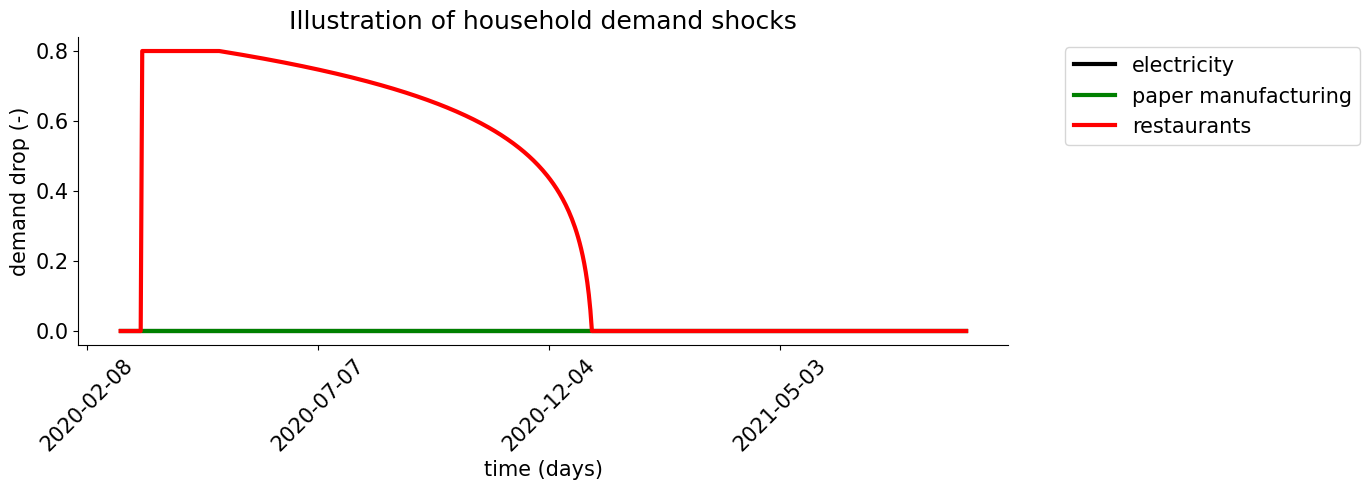

In [17]:
for idx,time in enumerate(simtime):
    epsilon_t = household_demand_shock(time,{}, params['epsilon_D'], params['t_start_lockdown'], params['t_end_lockdown'], params['t_end_pandemic'], params['c_s'], params['on_site'])
    if idx == 0:
        epsilon = np.expand_dims(epsilon_t,axis=1)
    else:
        epsilon = np.append(epsilon, np.expand_dims(epsilon_t,axis=1), axis=1)

fig,ax = plt.subplots(figsize=(12,4))
plottime = 600
ax.plot(simtime,epsilon[23,:],color='black')
ax.plot(simtime,epsilon[7,:],color='green')
ax.plot(simtime,epsilon[-28,:],color='red')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title('Illustration of household demand shocks')
ax.set_xlabel('time (days)')
ax.set_ylabel('demand drop (-)')
lgd=ax.legend(['electricity','paper manufacturing','restaurants'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
fig.savefig('demand_shocks.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Illustrate long-term expectation of income

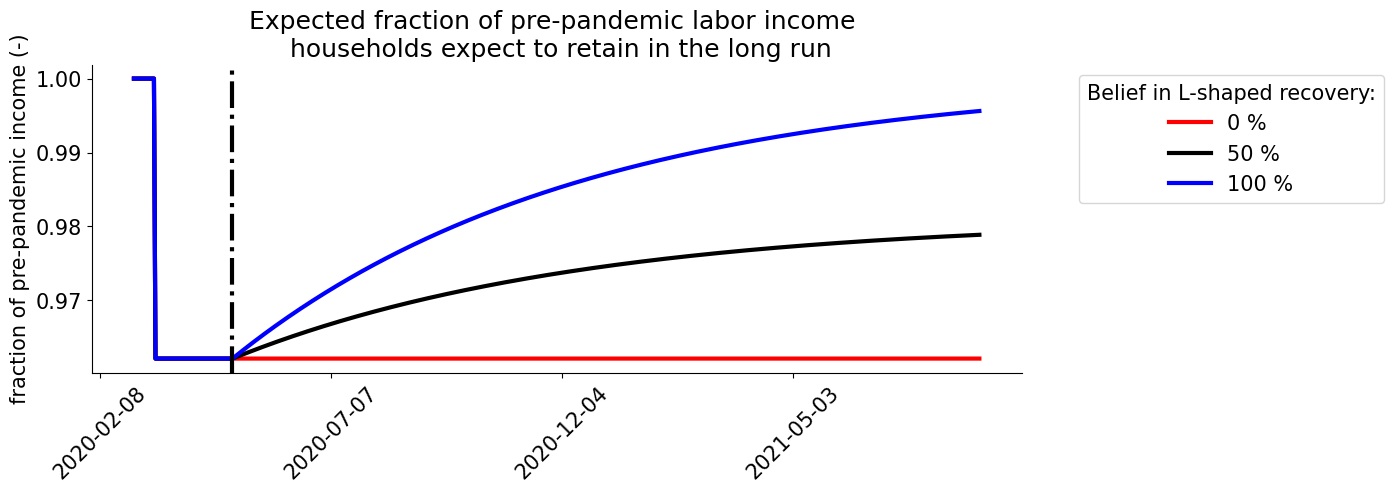

In [18]:
fig,ax = plt.subplots(figsize=(12,4))

color=['red','black','blue']
i=0
for L in [0,0.5,1]:
    zeta=[]
    for time in simtime:
        zeta.append(compute_income_expectations(time,{},{},params['t_start_lockdown'],params['t_end_lockdown'],params['l_0'],params['l_start_lockdown'],params['rho'],L))
    ax.plot(simtime,zeta,color=color[i])
    i=i+1
    
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.axvline(params['t_end_lockdown'],color='black',ls='-.')
ax.set_title('Expected fraction of pre-pandemic labor income \n households expect to retain in the long run')
ax.set_ylabel('fraction of pre-pandemic income (-)')
lgd=ax.legend(['0 %','50 %', '100 %'],bbox_to_anchor=(1.05, 1), loc='upper left',title='Belief in L-shaped recovery:')
ax.grid(False)
fig.savefig('l_p.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Simulation results

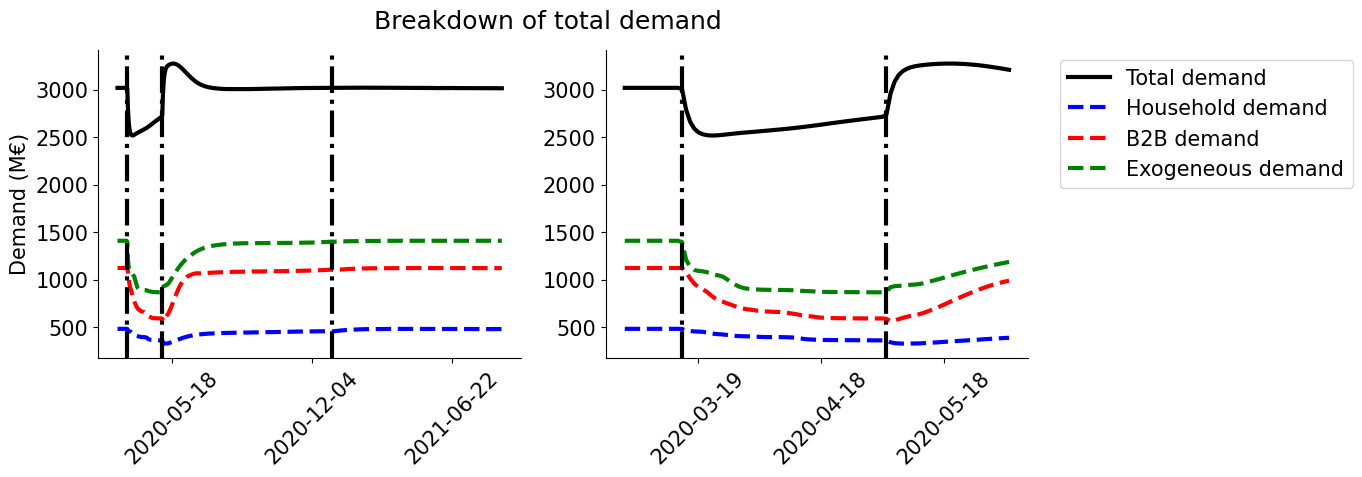

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(simtime,out['d'].sum(dim='NACE64'),color='black')
ax1.plot(simtime,out['c'].sum(dim='NACE64'),color='blue',ls='--')
ax1.plot(simtime,out['O'].sum(dim='NACE64'),color='red',ls='--')
ax1.plot(simtime,out['f'].sum(dim='NACE64'),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.grid(False)

ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['d'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='black')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['c'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='blue',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['O'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='red',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['f'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Total demand','Household demand','B2B demand','Exogeneous demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(False)
plt.show()

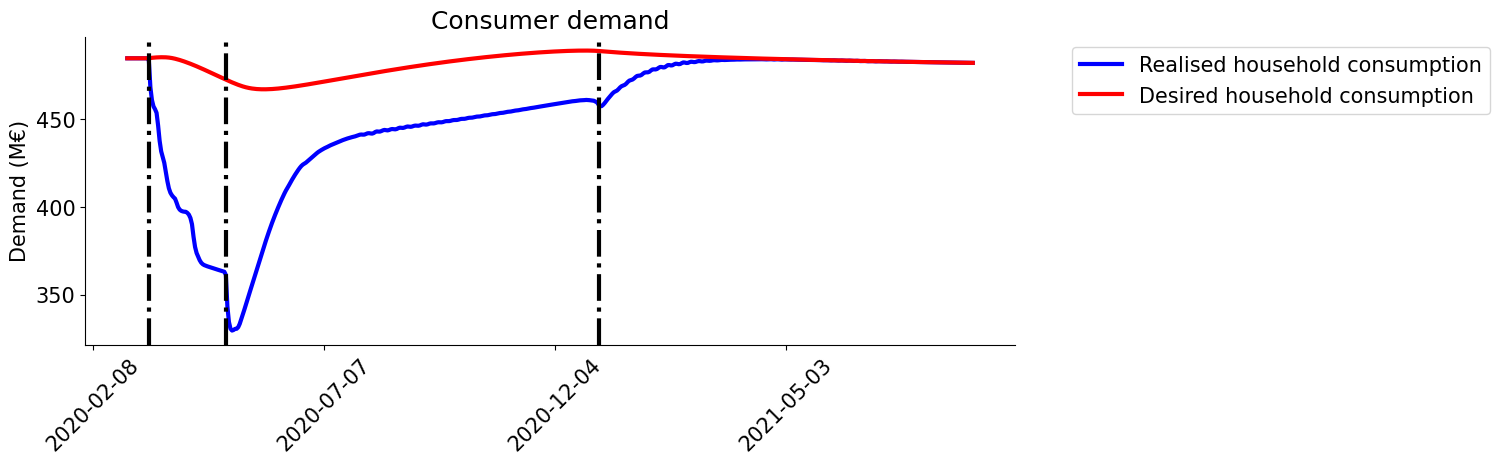

In [20]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(simtime,out['c'].sum(dim='NACE64'),color='blue')
ax.plot(simtime,out['c_desired'].sum(dim='NACE64'),color='red')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Demand (M€)')
lgd=ax.legend(['Realised household consumption','Desired household consumption'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
plt.show()

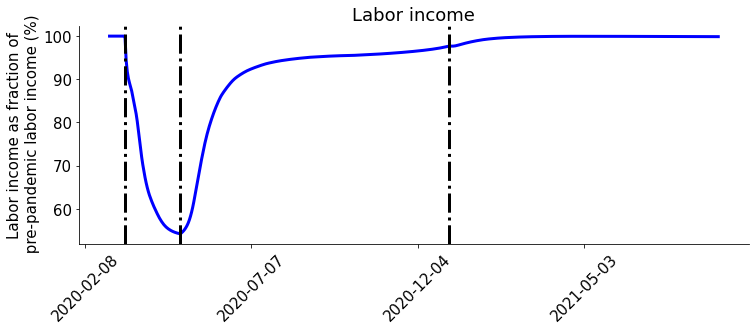

In [29]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(simtime,(out['l'].sum(dim='NACE64')/np.sum(params['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid(False)
plt.show()

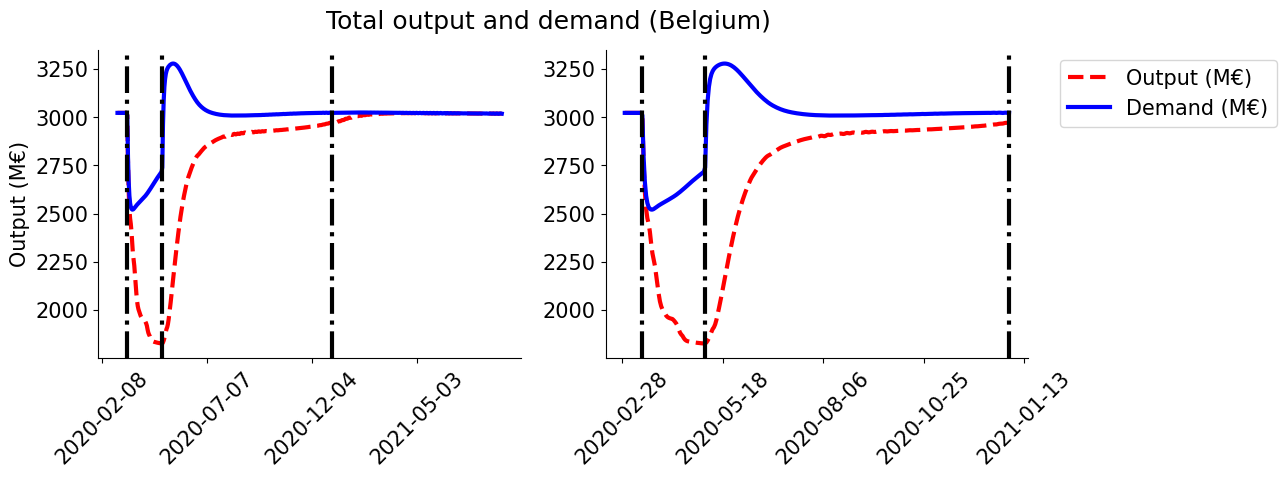

In [21]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(12,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(simtime,out['x'].sum(dim='NACE64'),color='red',ls='--')
ax1.plot(simtime,out['d'].sum(dim='NACE64'),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_ylabel('Output (M€)')
ax1.grid(False)

ax2.plot(out['date'].sel(date=slice(start_date, t_end_pandemic)),out['x'].sum(dim='NACE64').sel(date=slice(start_date, t_end_pandemic)),color='red',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_pandemic)),out['d'].sum(dim='NACE64').sel(date=slice(start_date, t_end_pandemic)),color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_pandemic,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(False)
plt.show()

In [31]:
pd.read_excel("../../data/interim/economical/conversion_matrices.xlsx", sheet_name = 'NACE 21 to NACE 10', header=[0], index_col=[0])

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
A,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"B, C, D, E",0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G-H-I,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
K,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
L,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
M-N,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
"O, P, Q",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
"R, S, T",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [38]:
def NACE64toNACE10(state_name,out):
    for idx,date in enumerate(out['date'].values):
        if idx == 0:
            aggregated_state = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(out[state_name].sel(date=date).values,axis=1))))
        else:
            aggregated_state = np.append(aggregated_state, np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(out[state_name].sel(date=date).values,axis=1)))), axis=1)
    return aggregated_state

In [39]:
x_10 = NACE64toNACE10('x',out)

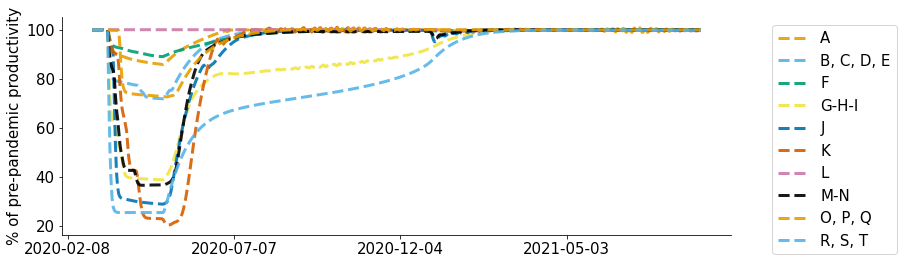

In [40]:
labels=pd.read_excel("../../data/interim/economical/conversion_matrices.xlsx", sheet_name = 'NACE 21 to NACE 10', header=[0], index_col=[0]).index.values

fig,ax=plt.subplots(figsize=(12,4))
for i in range(x_10.shape[0]):
    ax.plot(simtime,x_10[i,:]/x_10[i,0]*100,ls='--',linewidth=3, alpha=0.9)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid(False)
ax.set_ylabel('% of pre-pandemic productivity')
ax.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')
plt.show()

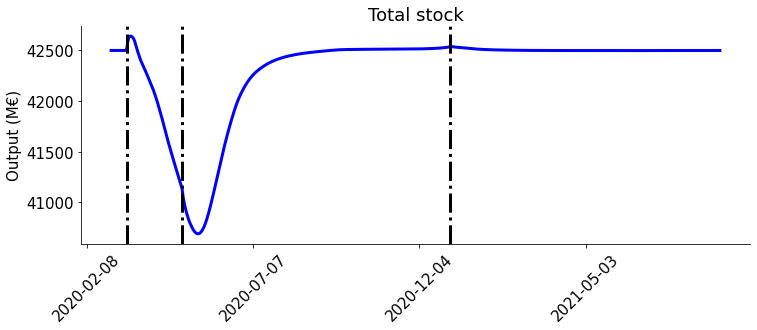

In [41]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(simtime,out['S'].sum(dim='NACE64').sum(dim='NACE64'),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Output (M€)')
ax.grid(False)
plt.show()

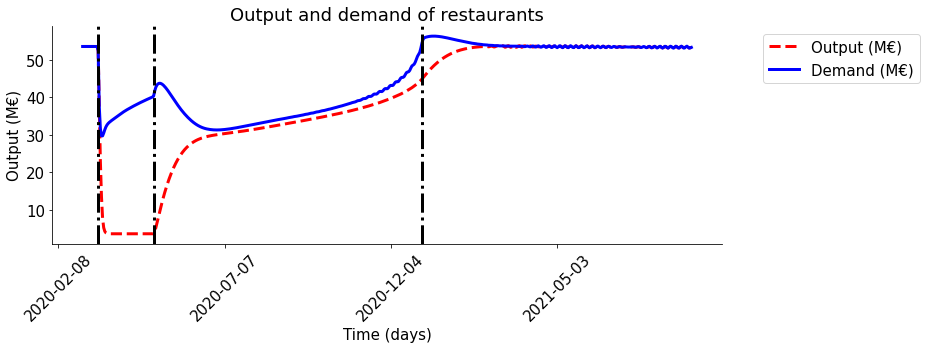

In [43]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(simtime,out['x'][-28,:],color='red',ls='--')
ax.plot(simtime,out['d'][-28,:],color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Output and demand of restaurants')
ax.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid(False)
plt.show()

## To labor shock or not to labor shock

In [44]:
params.update({'l_s': np.zeros(63)})
model = models.Economic_Model(initial_states, params, coordinates=coordinates,
                              time_dependent_parameters={'epsilon_S': labor_supply_shock,
                                                         'epsilon_D': household_demand_shock,
                                                         'epsilon_F': other_demand_shock,
                                                         'b': government_furloughing,
                                                         'zeta': compute_income_expectations})
out_no_labor_shock = model.sim(end_date, start_date=start_date, warmup=0)

/home/twallema/Documents/PhD/Corona/Python/git/pySODM/src/pySODM/models/base.py:333: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  while np.array(y0).ndim > 1:
/home/twallema/Documents/PhD/Corona/Python/git/pySODM/src/pySODM/models/base.py:337: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = fun(pd.Timestamp('2020-09-01'), np.array(y0), self.parameters)
/home/twallema/Documents/PhD/Corona/Python/git/pySODM/src/pySODM/models/base.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lis

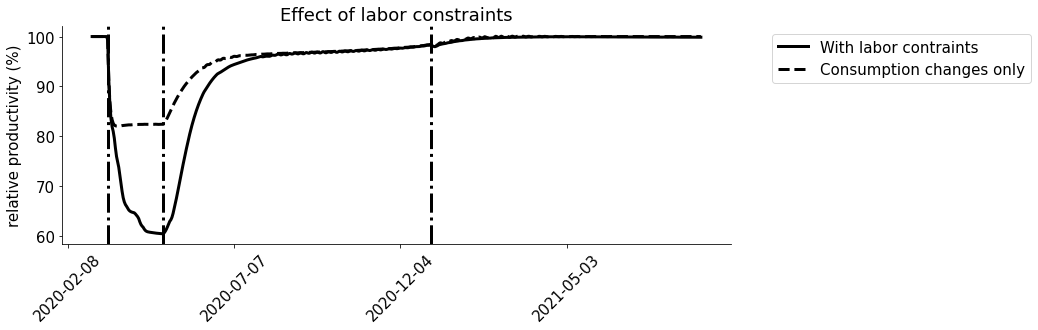

In [45]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(simtime,out['x'].sum(dim='NACE64')/out['x'].sum(dim='NACE64').sel(date=simtime[0])*100,color='black')
ax.plot(out_no_labor_shock['date'],out_no_labor_shock['x'].sum(dim='NACE64')/out['x'].sum(dim='NACE64').sel(date=simtime[0])*100,color='black',ls='--')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Effect of labor constraints')
ax.set_ylabel('relative productivity (%)')
lgd=ax.legend(['With labor contraints','Consumption changes only'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
plt.show()